<a href="https://colab.research.google.com/github/zainraza08/SciMachLearning/blob/main/MiniProject_AmericanHouseholdSurvey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#American Household Survey Analysis by Muhammad Zain Raza



# Libraries

Importing Libraries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import xgboost

In [3]:
!pip install --upgrade git+https://github.com/afarahi/kllr.git
import kllr as kl

  Cloning https://github.com/afarahi/kllr.git to /tmp/pip-req-build-o58cpjd7
  Running command git clone --filter=blob:none --quiet https://github.com/afarahi/kllr.git /tmp/pip-req-build-o58cpjd7
  Resolved https://github.com/afarahi/kllr.git to commit 26a35bc2311f4fe823fc6fc53dce829814a7cd5e
  Preparing metadata (setup.py) ... done
  Created wheel for kllr: filename=kllr-2.101-py3-none-any.whl size=22255 sha256=529e580c494bf75096094604bc3e52d2316001ad4e27e47a47ca46e5f4ce9de2
  Stored in directory: /tmp/pip-ephem-wheel-cache-admahphu/wheels/33/6e/9f/481dd0e0b2e8def17700ca0a14d0f09a358d24ecb78fb0ceb5
Successfully built kllr


# Calibration and Best Splitting Threshold

In this mini-project, we want to explore the role of calibration and the best splitting threshold under a simple $\{0, 1\}$ cost function and a more complex utility function. Before that we go through data exploration, model selection, hyper-parameter tuning, and at the end we will get back to our main question of decision-making and the best splitting threshold.

First, let's load the dataset, `AHS_2019_Cleaned.csv`.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/afarahi/Scientific-Machine-Learning/main/AHS_2019_Cleaned.CSV').drop('Unnamed: 0', axis=1)
df.head()

,BLACK,HHSEX,METRO,HHGRAD,HHMAR,HHCITSHP,HHAGE,NUMPEOPLE,HINCP,DIVISION,OWNER
0,0.0,1,1.0,44,1,1,52,3,5.409933,5,1.0
1,0.0,2,1.0,44,4,1,80,2,5.303196,1,1.0
2,0.0,1,1.0,47,1,1,72,2,4.825426,7,1.0
3,1.0,2,1.0,40,6,1,60,1,4.544068,4,0.0
4,0.0,2,1.0,39,3,1,80,2,4.309630,4,0.0


### Understanding Data

A definition of the variables is provided here. These definitions are taken from [2019 AHS definitions](https://www2.census.gov/programs-surveys/ahs/2019/2019\%20AHS\%20Definitions.pdf). If you are interested in learning more about each value please consult with the documentation. Here all the categorical variables are turned into a numeric variable, to see the associated value lables please download [this zip file](https://www2.census.gov/programs-surveys/ahs/2019/AHS%202019%20Value%20Labels%20Package.zip) and check out the `AHS 2019 Value Labels.csv`.

**Owner.** An owner is someone whose name is on the deed, mortgage, or contract to purchase. In some housing projects for the elderly, the residents can ``purchase'' a unit and pay monthly maintenance fees (including, for example, health, recreation, security, etc.). Such units are treated as owner-occupied. The ``purchaser'' cannot sell the unit, and upon death, ownership reverts to the sponsoring organization; no inheritance claim can occur.

**Household and count of households.** A household comprises all people who occupy a particular housing unit as their usual residence or who live there at the time of the interview and have no usual residence elsewhere. The usual residence is where the person lives and sleeps most of the time. This place is not necessarily the same as a legal, voting, or domicile residence. Households include not only occupants related to the householder but also any lodgers, roomers, boarders, partners, wards, foster children, and resident employees who share the living quarters of the householder. It includes people temporarily away for reasons such as visiting, traveling in connection with their jobs, attending school, in general hospitals, and in other temporary relocations. By definition, the count of households is the same as the count of occupied housing units.

**Black.** The classification of ‘‘race’’ refers to the race of the householder occupying the housing unit. The concept of race, as used by the Census Bureau, does not denote a clear-cut scientific definition of biological stock. Race is determined based on a question that asks for self-identification of a person's race. Respondents who refused to answer or do not know are entered as such
and imputed. Here we use a binary variable Black to indicade whether a household has anyone that self-identify as Black (`BLACK=1`) or not (`BLACK=0`).

**Income.** The survey covers total money income in the 12 months before the interview. It covers people age 16 and older (age 14 and older before 1999) currently living in the housing unit, even if they lived elsewhere during some of the previous 12 months. ``Money income'' is the income received on a regular basis (exclusive of certain money receipts such as capital gains and lump-sum payments) before payments for personal income taxes, social security, union dues, Medicare deductions, etc. It includes income received from wages, salary, commissions, bonuses, and tips; self-employment income from own nonfarm or farm businesses, including proprietorships and partnerships; interest, dividends, net rental income, royalty income, or income from estates and trusts; Social Security or Railroad Retirement income; Supplemental Security Income (SSI); any cash public assistance or welfare payments from the state or local welfare office; retirement, survivor, or disability benefits; and any other sources of income received regularly such as Veterans' (VA) payments, unemployment and/or worker's compensation, child support, and alimony. Respondents are asked to report income from the job at which the respondent worked the greatest number of weeks during the previous 12 months. A person's longest job is not necessarily the longest they have ever had. If the person had two or more jobs of equal length in the previous 12 months, the most recent job is considered the longest. The reported numbers are $log_{10}(income)$.

**Citizenship of householder.** Place of birth was asked for each householder and every household member. There are five categories of citizenship status: (1) born in the United States, (2) born in Puerto Rico or another U.S. outlying area, (3) born abroad of U.S. citizen parents, (4) naturalized citizens, or (5) noncitizens. People born in the United States are citizens at birth. Citizen by birth refers to categories 1-4 above.

**Division.** The U.S. is divided into four regions (Northeast, Midwest, South, and West) nine divisions.

*Northeast.* The Northeast region is comprised of two
Census Divisions - New England and Middle Atlantic -
as well as the following states: Maine, New Hampshire, Vermont, Massachusetts, Rhode Island, Connecticut, New York, Pennsylvania, and New Jersey.

*Midwest.* The Midwest region is comprised of two Census Divisions–East North Central and West North Central–as well as the following states: Ohio, Indiana, Illinois, Michigan, Wisconsin, Minnesota, Iowa, Missouri, Kansas, Nebraska, North Dakota, and South Dakota.

*South.* The South region is comprised of three Census Divisions–South Atlantic, East South Central, and West South Central–as well as the following states: Delaware, Maryland, District of Columbia, Virginia, West Virginia, North Carolina, South Carolina, Georgia, Florida, Alabama, Mississippi, Tennessee, Kentucky, Arkansas, Louisiana, Oklahoma, and Texas.

*West.* The West region is comprised of two Census Divisions– Mountain and Pacific–as well as the following states: Montana, Wyoming, Colorado, New Mexico, Arizona, Utah, Idaho, Alaska, Washington, Oregon, Nevada, California, and Hawaii.

**Metropolitan/micropolitan area.** Metropolitan areas are composed of whole counties (towns in New England) that have significant levels of commuting and contiguous urban areas in common. They may cross state lines and usually include large amounts of rural land and farmland, provided the county or town as a whole qualifies. A metropolitan or micropolitan statistical area's geographic composition, or list of geographic components at a particular point in time, is referred to as its "delineation." Metropolitan and micropolitan statistical areas are delineated by the U.S. Office of Management and Budget (OMB) and are the result of the application of published standards to Census Bureau data.

### Data Exploration

First, we want to explore this data set to see what we can learn from it.

Throught this project, the outcome variable is homeownership. We want to know whether we can predict who is a homeonwer and which householder is not using their household catacteristics.


Income is the most important variable in guessing whether a householder is a homeowner as one might expect. Hence, let's use income as our independent variable in the following visualizations.

We'll make three plots using the function `Plot_Fit_Summary_Split` in `KLLR` package. This function allows stratifying the data on a third variable. For instance, `Plot_Fit_Summary_Split(df, 'X', 'Y', 'Z', split_bins=[0.0, 10, 20, 30], ...)` stratify `df`, a DataFrame object, on variable `Z` into three bins $Z \in [0, 10)$,  $Z \in [10, 20)$, and  $Z \in [20, 30)$ and then fit kllr to each subset. See the documentation for more details.


Now, using this function and 50 data bootstraps (set `nBootstrap = 50`). we show the KLLR fits, without visualizing the raw data (set `show_data=False`). We make the following visualizations:

(1) Stratify data on age (People < 30, People between 30 and 50, people between 50 and 60, and anyone above 60), and show the average homeownership as a function of income for each age group on the same plot.

(2) Split the population into those with the head less than Bachelor's degree and those with at least a Bachelor's degree. Then plot the average homeownership as a function of householder's age for each education group on the same plot.

(3) Stratify on variable 'BLACK' and plot the average homeownership as a function of income for race group on the same plot.

(4) Stratify data on both race and marital status and then plot homeownership as a function of income for race group and marital status group on the same plot.

100%|██████████| 34/34 [00:05<00:00,  5.67it/s]


(0.0, 1.0)

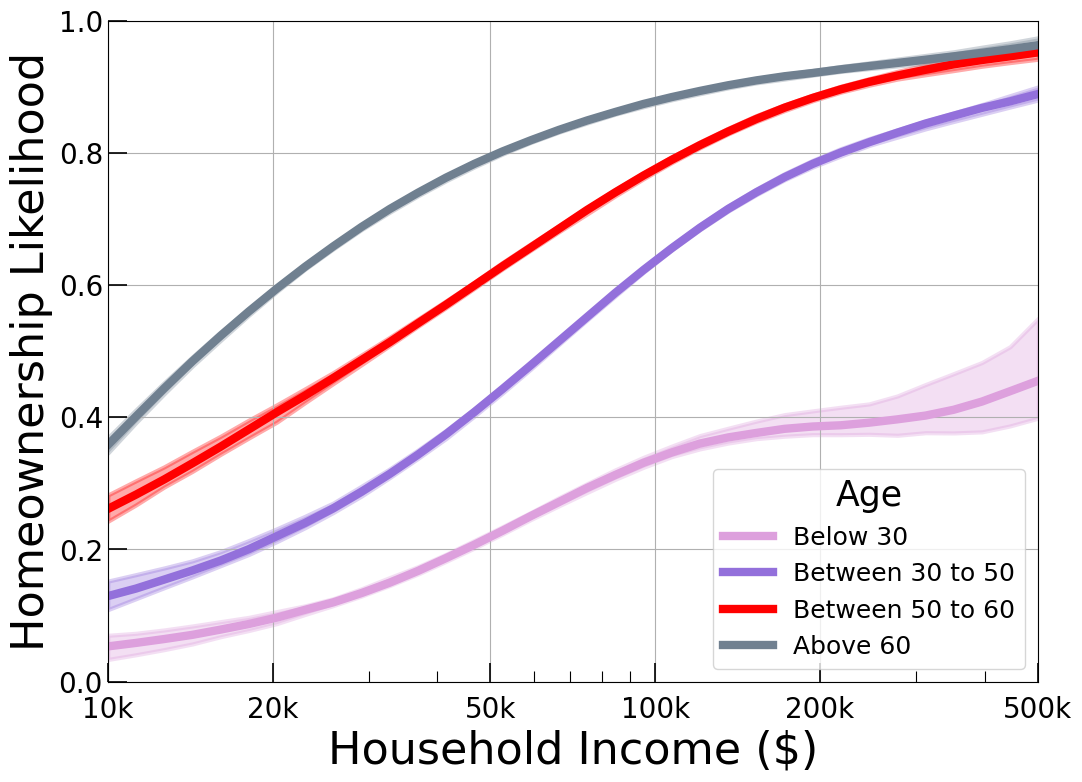

In [5]:
_, ax = kl.Plot_Fit_Summary_Split(df, 'HINCP', 'OWNER', 'HHAGE', split_bins=[14, 29, 49, 59, 90],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'mediumpurple', 'red', 'slategrey'],
                                  labels=['Household Income', 'Ownership Rate', 'Age'], cmap = None, ax = None)

ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)

ax[0].lines[0].set_label(r'Below 30')
ax[0].lines[1].set_label(r'Between 30 to 50')
ax[0].lines[2].set_label(r'Between 50 to 60')
ax[0].lines[3].set_label(r'Above 60')

for line in ax[0].get_lines()[:]: line.set_linewidth(6)

ax[0].legend(title = "Age", title_fontsize = 25, loc=4, prop={'size':18})

ax[0].set_ylabel('Homeownership Likelihood', size=32)
ax[0].set_xlabel('Household Income ($)', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])
ax[0].set_xlim(1e4, 5e5)
ax[0].set_ylim(0.0, 1.0)

100%|██████████| 34/34 [00:04<00:00,  7.00it/s]


(0.0, 1.0)

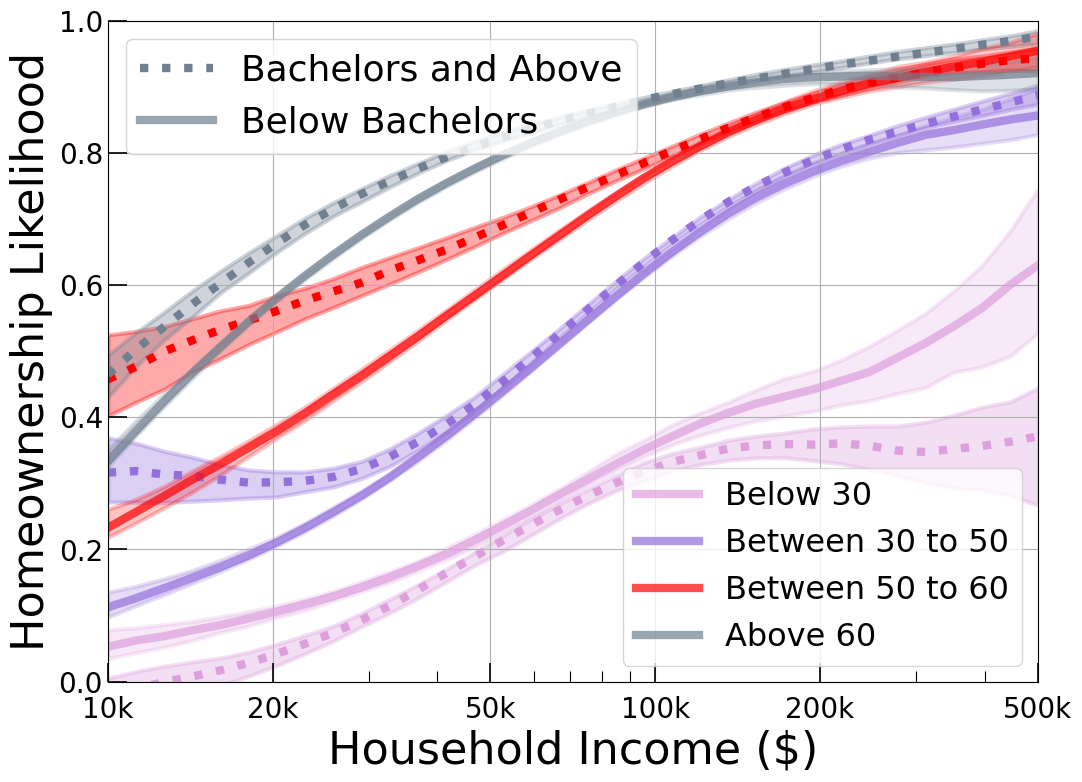

In [6]:
_, ax = kl.Plot_Fit_Summary_Split(df[::][df['HHGRAD']>=44], 'HINCP', 'OWNER', 'HHAGE', split_bins=[14, 29, 49, 59, 90],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], black_line=False, linestyle =':',
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'mediumpurple', 'red', 'slategrey'],
                                  labels=['Household Income', 'Ownership Rate', 'Age'], cmap = None, ax = None)

_, ax = kl.Plot_Fit_Summary_Split(df[::][df['HHGRAD']<44], 'HINCP', 'OWNER', 'HHAGE', split_bins=[14, 29, 49, 59, 90],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7],
                                  linestyle='-',  black_line=False, alpha=0.7,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25, fast_calc = False,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'mediumpurple', 'red', 'slategrey'], labels=['Household Income', 'Ownership Rate', 'Age'], ax=ax)


ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)

ax[0].lines[0].set_label(None)
ax[0].lines[1].set_label(None)
ax[0].lines[2].set_label(None)
ax[0].lines[3].set_label(None)
ax[0].lines[4].set_label(r'Below 30')
ax[0].lines[5].set_label(r'Between 30 to 50')
ax[0].lines[6].set_label(r'Between 50 to 60')
ax[0].lines[7].set_label(r'Above 60')

for line in ax[0].get_lines()[:]: line.set_linewidth(6)

legend1 = ax[0].legend([ax[0].lines[3], ax[0].lines[7]], ["Bachelors and Above", "Below Bachelors"], prop={'size':26}, loc=2)
ax[0].add_artist(legend1)
ax[0].legend(loc=4, prop={'size':23})

ax[0].set_ylabel('Homeownership Likelihood', size=32)
ax[0].set_xlabel('Household Income ($)', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])
ax[0].set_xlim(1e4, 5e5)
ax[0].set_ylim(0.0, 1.0)

100%|██████████| 34/34 [00:05<00:00,  6.54it/s]


(0.0, 1.0)

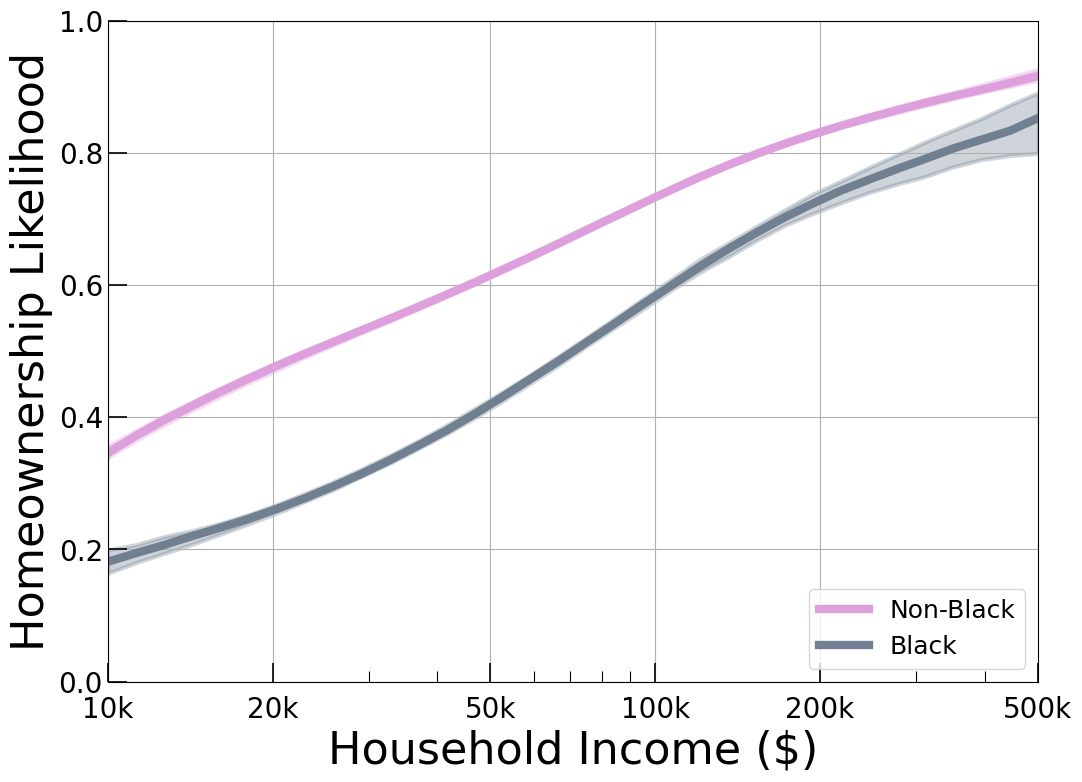

In [7]:
_, ax = kl.Plot_Fit_Summary_Split(df, 'HINCP', 'OWNER', 'BLACK', split_bins=[-1, 0.5, 1.5],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7], black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'slategrey'],
                                  labels=['Household Income', 'Ownership Rate', 'Age'], cmap = None, ax = None)

ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)

ax[0].lines[0].set_label(r'Non-Black')
ax[0].lines[1].set_label(r'Black')

for line in ax[0].get_lines()[:]: line.set_linewidth(6)

ax[0].legend(loc=4, prop={'size':18})

ax[0].set_ylabel('Homeownership Likelihood', size=32)
ax[0].set_xlabel('Household Income ($)', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])
ax[0].set_xlim(1e4, 5e5)
ax[0].set_ylim(0.0, 1.0)

100%|██████████| 34/34 [00:02<00:00, 11.68it/s]


(0.0, 1.0)

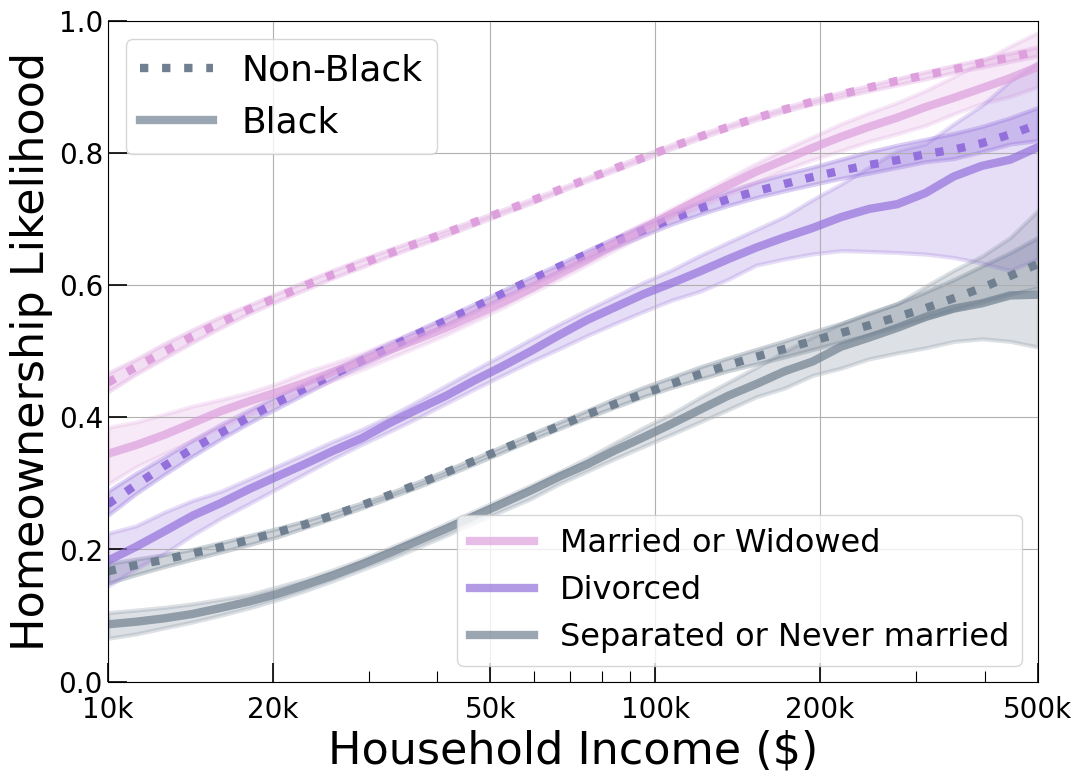

In [8]:
_, ax = kl.Plot_Fit_Summary_Split(df, 'HINCP', 'OWNER', 'HHMAR', split_bins=[0.5, 3.5, 4.5, 6.5],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7],
                                  linestyle=':',  black_line=False,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'mediumpurple', 'slategrey'],
                                  labels=['Household Income', 'Ownership Rate', 'X'], cmap = None, ax=None)

_, ax = kl.Plot_Fit_Summary_Split(df[::][df['BLACK']==1], 'HINCP', 'OWNER', 'HHMAR', split_bins=[0.5, 3.5, 4.5, 6.5],
                                  split_mode = 'Data', y_err=None, bins=34, xrange=[4, 5.7],
                                  linestyle='-',  black_line=False, alpha=0.7,
                                  nBootstrap=50, verbose = True, percentile=[16., 84.], kernel_type='gaussian', kernel_width=0.25, fast_calc = False,
                                  show_data=False, xlog=True, ylog=False, color=['plum', 'mediumpurple', 'slategrey'], labels=['Household Income', 'Ownership Rate', 'X'], ax=ax)


ax.flat[1].set_visible(False)
ax.flat[2].set_visible(False)

ax[0].lines[0].set_label(None)
ax[0].lines[1].set_label(None)
ax[0].lines[2].set_label(None)
ax[0].lines[3].set_label(r'Married or Widowed')
ax[0].lines[4].set_label(r'Divorced')
ax[0].lines[5].set_label(r'Separated or Never married')

for line in ax[0].get_lines()[:]: line.set_linewidth(6)

legend1 = ax[0].legend([ax[0].lines[2], ax[0].lines[5]], ["Non-Black", "Black"], prop={'size':26}, loc=2)
ax[0].add_artist(legend1)
ax[0].legend(loc=4, prop={'size':23})

ax[0].set_ylabel('Homeownership Likelihood', size=32)
ax[0].set_xlabel('Household Income ($)', size=32)
ax[0].tick_params(labelbottom=True)
ax[0].set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ax[0].set_xticklabels(['10k', '20k', '50k', '100k', '200k', '500k'])
ax[0].set_xlim(1e4, 5e5)
ax[0].set_ylim(0.0, 1.0)

### Model selection and hyper-parameter tuning

To select the best model and its hyper-parameters, we will split the sample into a 66% training set and a 33% validation set. We will only train two models, a Random Forest Regressor and a XGBoost Regressor, using the libraries that have been loaded.

Our first goal is to find the `max_depth` value that maximizes the AUC score. We will not change the other hyper-parameters and will use their default values.

We want to obtain not only a point estimation for the AUC score but also quantify the uncertainty of the AUC score. To achieve this, we will run 10 random train/test (66/33%) splits for each model and each `max_depth` value. We will then plot the mean and standard deviation of the AUC score as a function of `max_depth` for each model.

After that, we will determine the superior model and use it as our reference model.

In [9]:
features = ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
dependent_var = ['OWNER']

X = df[features]
y = df[dependent_var]

max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [10]:
rf =  RandomForestRegressor
xgb = xgboost.XGBRegressor

rf_auc_mean = []
rf_auc_std = []
xgb_auc_mean = []
xgb_auc_std = []

# Define number of iterations
num_iterations = 10

# Loop through max_depth values
for depth in max_depth_array:
    rf_auc_scores = []
    xgb_auc_scores = []
    for i in range(num_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
        # Random Forest Regressor
        rf_model = rf(max_depth=depth)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, rf_pred)
        rf_auc = auc(fpr, tpr)
        rf_auc_scores.append(rf_auc)

        # XGBoost Regressor
        xgb_model = xgb(max_depth=depth)
        xgb_model.fit(X_train, y_train)
        xgb_pred = xgb_model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, xgb_pred)
        xgb_auc = auc(fpr, tpr)
        xgb_auc_scores.append(xgb_auc)

    # Calculate mean and std of AUC scores for each model at current max_depth
    rf_auc_mean.append(np.mean(rf_auc_scores))
    rf_auc_std.append(np.std(rf_auc_scores))
    xgb_auc_mean.append(np.mean(xgb_auc_scores))
    xgb_auc_std.append(np.std(xgb_auc_scores))

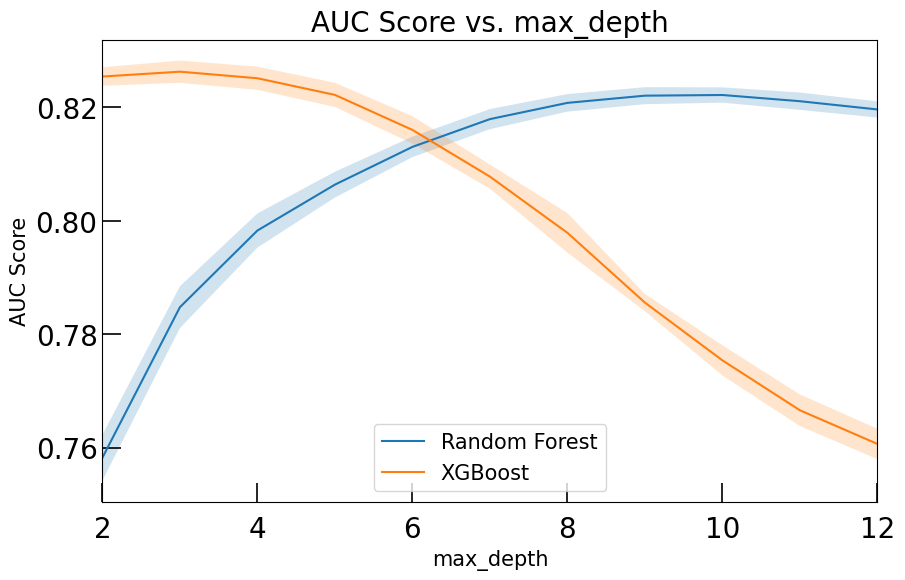

In [11]:
plt.figure(figsize=(10,6))
plt.plot(max_depth_array, rf_auc_mean, label='Random Forest')
plt.plot(max_depth_array, xgb_auc_mean, label='XGBoost')
rf_error = np.array(rf_auc_std)
xgb_error = np.array(xgb_auc_std)
plt.fill_between(max_depth_array, rf_auc_mean-rf_error,rf_auc_mean+rf_error, alpha = 0.2)
plt.fill_between(max_depth_array, xgb_auc_mean-xgb_error, xgb_auc_mean+xgb_error, alpha = 0.2)
plt.xlabel('max_depth',size=15)
plt.ylabel('AUC Score',size=15)
plt.title('AUC Score vs. max_depth', size=20)
plt.xlim([2,12])
plt.legend(fontsize = 15)
plt.show()

### Evaluation (13 points)

From here, we will define three models. The first model is a `RandomForestRegressor` with `max_depth=3`. This will be our base model. The second model, is the best model determined from the above excercise. The last model will be a calibrated `RandomForestClassifier` with `max_depth=10`.

We will plot two ROC curve for each classifier, one for the test and one for the training sample, and report the AUC for the test sample on the plot.

Using this result, we select the best model of the three.

In [12]:
from sklearn.calibration import CalibratedClassifierCV

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state= 42)

clf_base = RandomForestRegressor(max_depth=3).fit(X_train, y_train)
clf_best = xgb(max_depth=3).fit(X_train, y_train)
clf_cali = CalibratedClassifierCV(RandomForestClassifier(max_depth = 10), method = 'isotonic').fit(X_train, y_train)

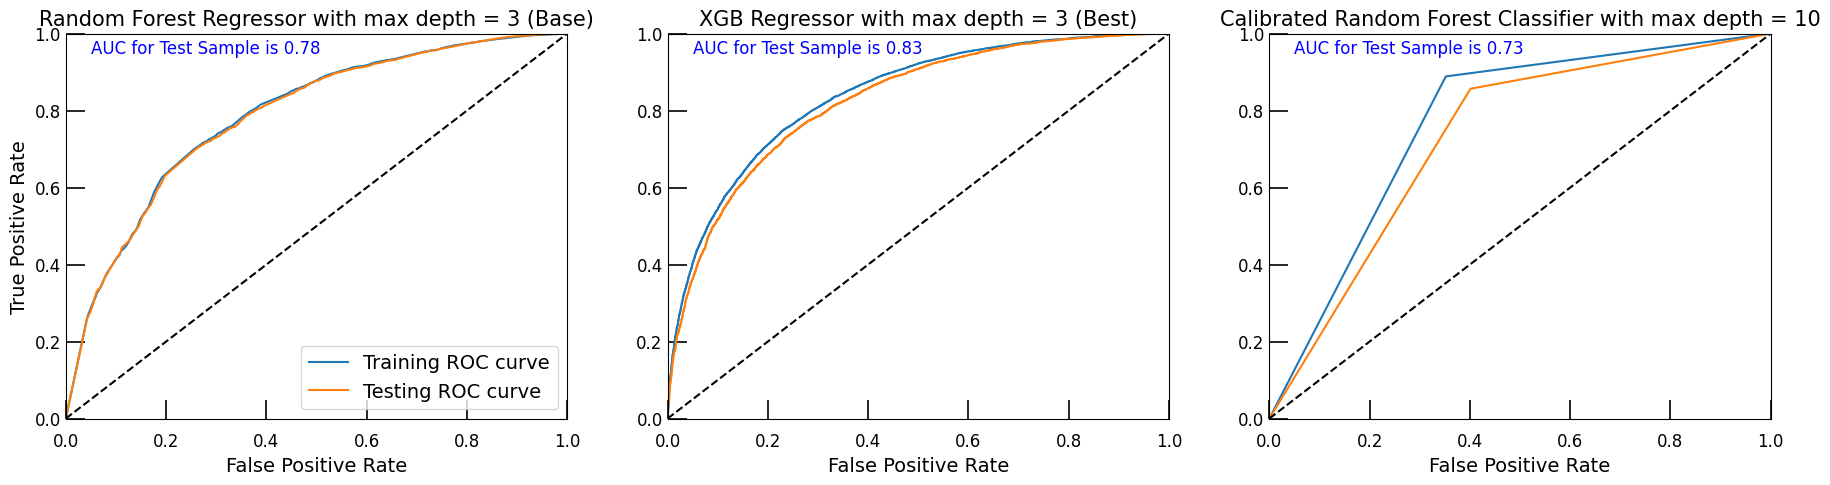

In [16]:
classifiers = [clf_base, clf_best, clf_cali]
names = ['Random Forest Regressor with max depth = 3 (Base)', 'XGB Regressor with max depth = 3 (Best)', 'Calibrated Random Forest Classifier with max depth = 10']
i = 0
plt.figure(figsize = (22,5))
for name, clf in zip(names, classifiers):
  pred_train = clf.predict(X_train)
  pred_test = clf.predict(X_test)
  fpr_train, tpr_train, thresholds = roc_curve(y_train, pred_train)
  fpr_test, tpr_test, thresholds = roc_curve(y_test, pred_test)
  plt.subplot(1,3,i+1)
  plt.plot(fpr_train, tpr_train, label = 'Training ROC curve')
  plt.plot(fpr_test, tpr_test, label = 'Testing ROC curve')
  plt.axline((0,0), slope= 1, linestyle = 'dashed', color = 'black')
  plt.title(name, size = 15, loc = 'center', wrap = True)
  plt.xlabel('False Positive Rate', size = 14)
  if i == 0:
    plt.ylabel('True Positive Rate', size = 14)
    plt.legend(loc = 4, fontsize = 14)
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xticks(size = 12)
  plt.yticks(size = 12)
  auc_test = round(auc(fpr_test, tpr_test),2)
  plt.text(0.05, 0.95, 'AUC for Test Sample is ' + str(auc_test), fontsize = 12, color = 'blue')
  i += 1

Now we will create two calibration curves for each classifier, one for the test and one for the training sample and then interpret the plot and discuss which model is calibrated and which model is miscalibrated.

Note that to make a calibration curve the model's prediction must be a number between 0 and 1. `RandomForestRegressor` and `XGBRegressor` are regression model and their prediction is not gauranteed to be between this range. We use the following formula to renormalize their prediction:

$$
p(x) = \frac{f(x) - \min(f(.))}{\max(f(.)) - \min(f(.))}
$$


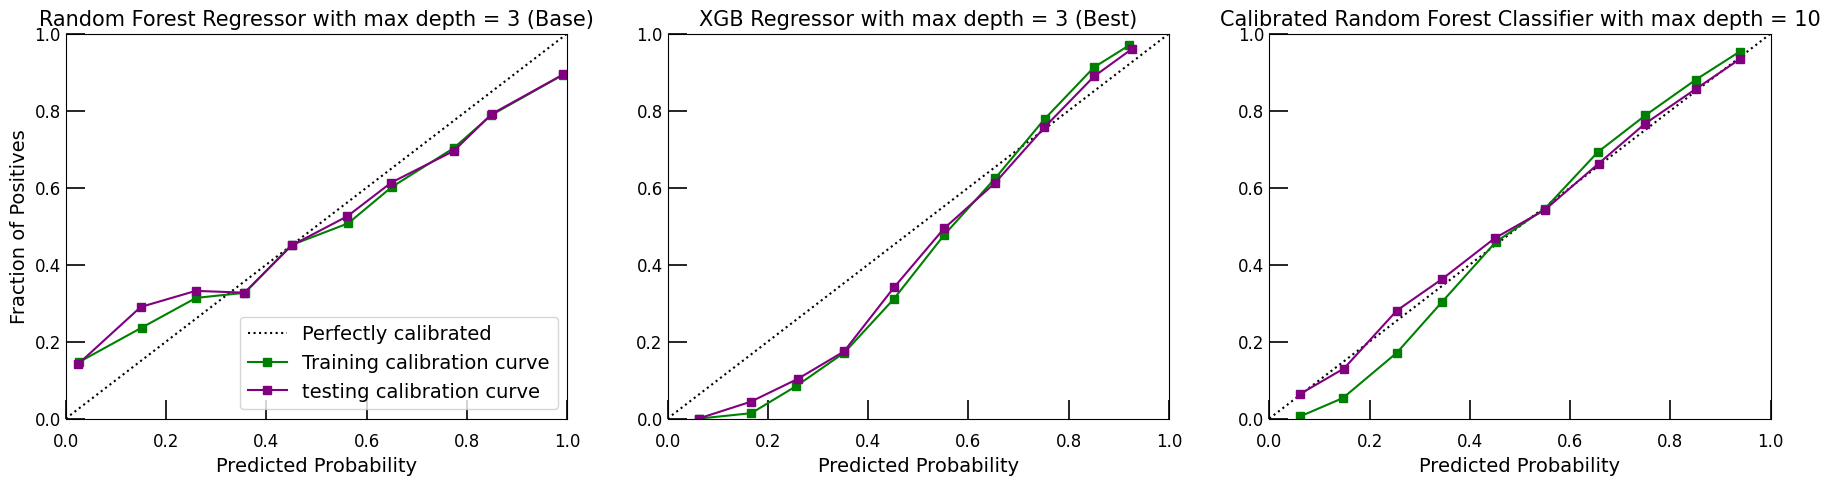

In [18]:
plt.figure(figsize = (22,5))
i=0
for name, clf in zip(names, classifiers):
  if clf == clf_base or clf == clf_best:
    probs_pos_train = clf.predict(X_train)
    probs_pos_test = clf.predict(X_test)
    probs_pos_train = (probs_pos_train - np.min(probs_pos_train))/(np.max(probs_pos_train)-np.min(probs_pos_train))
    probs_pos_test = (probs_pos_test - np.min(probs_pos_test))/(np.max(probs_pos_test)-np.min(probs_pos_test))
  else:
    probs_pos_train = clf.predict_proba(X_train)[:,1]
    probs_pos_test = clf.predict_proba(X_test)[:, 1]

  fop_train, mpv_train = calibration_curve(y_train, probs_pos_train, n_bins = 10)
  fop_test, mpv_test = calibration_curve(y_test, probs_pos_test, n_bins = 10)
  plt.subplot(1,3,i+1)
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  plt.plot(mpv_train, fop_train, "s-", color = 'green', label = 'Training calibration curve')
  plt.plot(mpv_test, fop_test, "s-", color = 'purple', label = 'testing calibration curve')
  plt.title(name, size = 15, loc = 'center', wrap = True)
  plt.xlabel('Predicted Probability', size = 14)
  if i == 0:
    plt.ylabel('Fraction of Positives', size = 14)
    plt.legend(loc = 4, fontsize = 14)
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xticks(size = 12)
  plt.yticks(size = 12)
  i+= 1

### Best Classification Threshold (5 points)

Our next aim is to check one of the main claims made in [this paper](https://link.springer.com/chapter/10.1007/978-3-540-30116-5_14). Specifically, they show the optimal decision rule, that is, the optimal function that maps a sample $x$ to one of the values of $C \in \{0, 1\}$, under the 0-1 cost function, is the maximum a- posteriori (MAP) rule
$$
  g(x) = \arg \max_{C \in \{0, 1\}} f(x)
$$
where $f(x)$ is the probabilistic classifier. This implies the optimal decision threshold is at $f(x) = 0.5$ for a calibrated classifier. Under this decision rule the error rate minimizes,
$$
 {\rm Err} = 1 - {\rm Accuracy} = \frac{FN + FP}{P + N}.
$$

To show this we make a plot that computes the error rate as a function of decision threshold for each classifier for the test sample and then interpret the result.

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 [Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7, '0.7')])

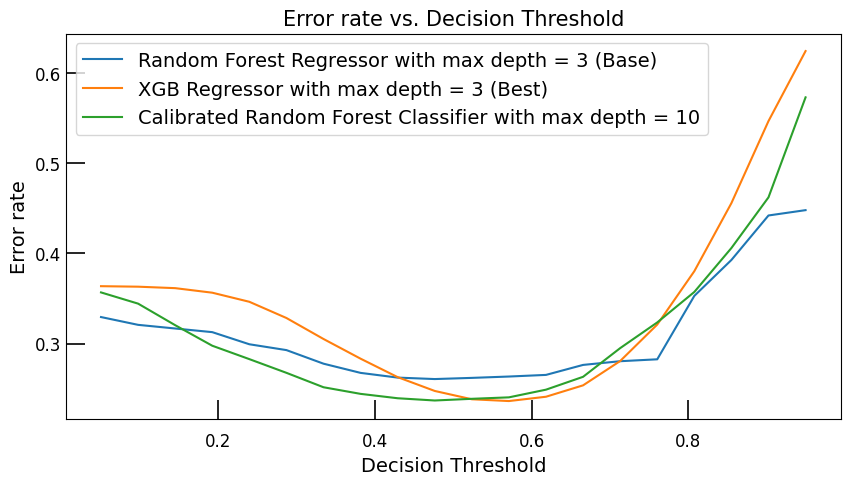

In [19]:
dec_threshold = np.linspace(0.05, 0.95, 20)
plt.figure(figsize = (10,5))
for name, clf in zip(names, classifiers):
  error= []
  for t in dec_threshold:
    if clf == clf_base or clf == clf_best:
      probs_pos_test = clf.predict(X_test)
      probs_pos_test = (probs_pos_test - min(probs_pos_test))/(max(probs_pos_test)-min(probs_pos_test))
      probs_pos_test=np.where(probs_pos_test>=t,1.0,0.0)
      accuracy = accuracy_score(y_test, probs_pos_test)
    else:
      probs_pos_test = clf.predict_proba(X_test)[:,1]
      accuracy = accuracy_score(y_test, probs_pos_test >= t)
    # probs_pos_test=np.where(probs_pos_test>=t,1.0,0.0)
    error.append(1-accuracy)
    # error.append(1-accuracy_score(y_test, probs_pos_test))
  plt.plot(dec_threshold, error, label=name)
plt.title('Error rate vs. Decision Threshold', size = 15, loc = 'center', wrap = True)
plt.xlabel('Decision Threshold', size = 14)
plt.ylabel('Error rate', size = 14)
plt.legend(loc = 2, fontsize = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)

### Decision Making Under Non-trivial Cost Function (8 points)


Now we suppose a non-trivial cost function that changes with the age of the housholder. Let's assume that the reward of TP = TN = 1, and the costs of the FP and FN are as following:


$$ C({\rm FP}) = (1 - {\rm Age} / 100) \times 2 $$

$$ C({\rm FN}) = (1 - {\rm Age} / 100) \times 0.5 $$

We write a function that computes the utility for a given decision threshold of ${\rm th}$.

$\hat{U} = \frac{1}{n_{\rm test}}\sum_{i=1}^{n_{\rm test}}\left[\mathbb{I}(y_i - \hat{f}_i) \times R(x_i, y_i) - |y_i - \hat{f}_i| \times C(x_i, y_i) \right]$

Finally we compute and report the utility of the test sample assuming ${\rm th} = 0.5$ for all three classifiers using the test sample.

In [20]:
def utility(p, y_true, age, th):

    p = np.where(p>=th,1,0).astype(int)
    y_true = y_true.astype(int)
    U_T = 0
    U_FP = 0
    U_FN = 0
    for pred, true, age in zip(p,y_true,age):
      if pred == true:
        U_T += 1
      elif pred == 1 and true == 0:
        U_FP += (1-age/100)*2
      else:
        U_FN += (1-age/100)*0.5
    U = (U_T - U_FP - U_FN) / len(p)

    return U


In [21]:
y_true = y_test.OWNER.to_numpy()
age = X_test.HHAGE.to_numpy()
th = 0.5

y_score = clf_base.predict(X_test)
p_base = (y_score - np.min(y_score) ) / (np.max(y_score) - np.min(y_score))

y_score = clf_best.predict(X_test)
p_best = (y_score - np.min(y_score) ) / (np.max(y_score) - np.min(y_score))

p_cali = clf_cali.predict_proba(X_test)[:,1]

print(" Base Classifier Utility (th = 0.5) = %0.2f"%utility(p_base, y_true, age, th))
print(" Best Classifier Utility (th = 0.5) = %0.2f"%utility(p_best, y_true, age, th))
print(" Calibrated Classifier Utility (th = 0.5) = %0.2f"%utility(p_cali, y_true, age, th))

 Base Classifier Utility (th = 0.5) = 0.56
 Best Classifier Utility (th = 0.5) = 0.57
 Calibrated Classifier Utility (th = 0.5) = 0.61


Now, we make a plot that shows the utility of the three model as a function of ${\rm th} \in [0, 1]$. and pick the best classifier


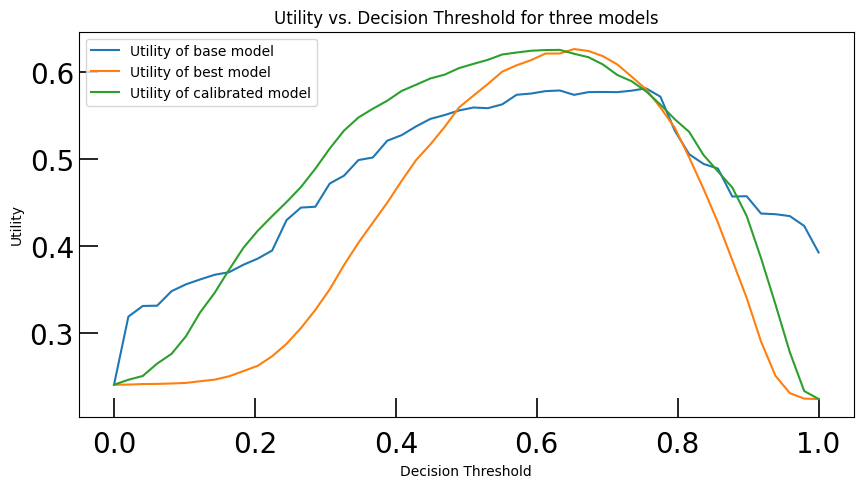

In [22]:
th = np.linspace(0,1,50)
utility_base = []
utility_best = []
utility_cali = []
for t in th:
  utility_base.append(utility(p_base, y_true, age, t))
  utility_best.append(utility(p_best, y_true, age, t))
  utility_cali.append(utility(p_cali, y_true, age, t))

plt.figure(figsize = (10,5))
plt.plot(th, utility_base, label = 'Utility of base model')
plt.plot(th, utility_best, label = 'Utility of best model')
plt.plot(th, utility_cali, label = 'Utility of calibrated model')

plt.ylabel('Utility')
plt.xlabel('Decision Threshold')
plt.title('Utility vs. Decision Threshold for three models')
plt.legend(loc = 2)

### Decision Fairness (5 points)

While the above threshold might be optimal for the whole population, this does not imply that this is the optimal deiciosn threshold for each sub-population.

Stratify the data into Black and non-Black households. For each set of households we make a similar plot as above (two panel plot, one for Black and one for non-Black households) and check the utility function for each population group

In [23]:
race = X_test.BLACK.to_numpy()
black_msk = race == 1
nonblack_msk = ~black_msk

Text(0.5, 1.0, 'Utility vs. Decision Threshold of three models for nonblack population')

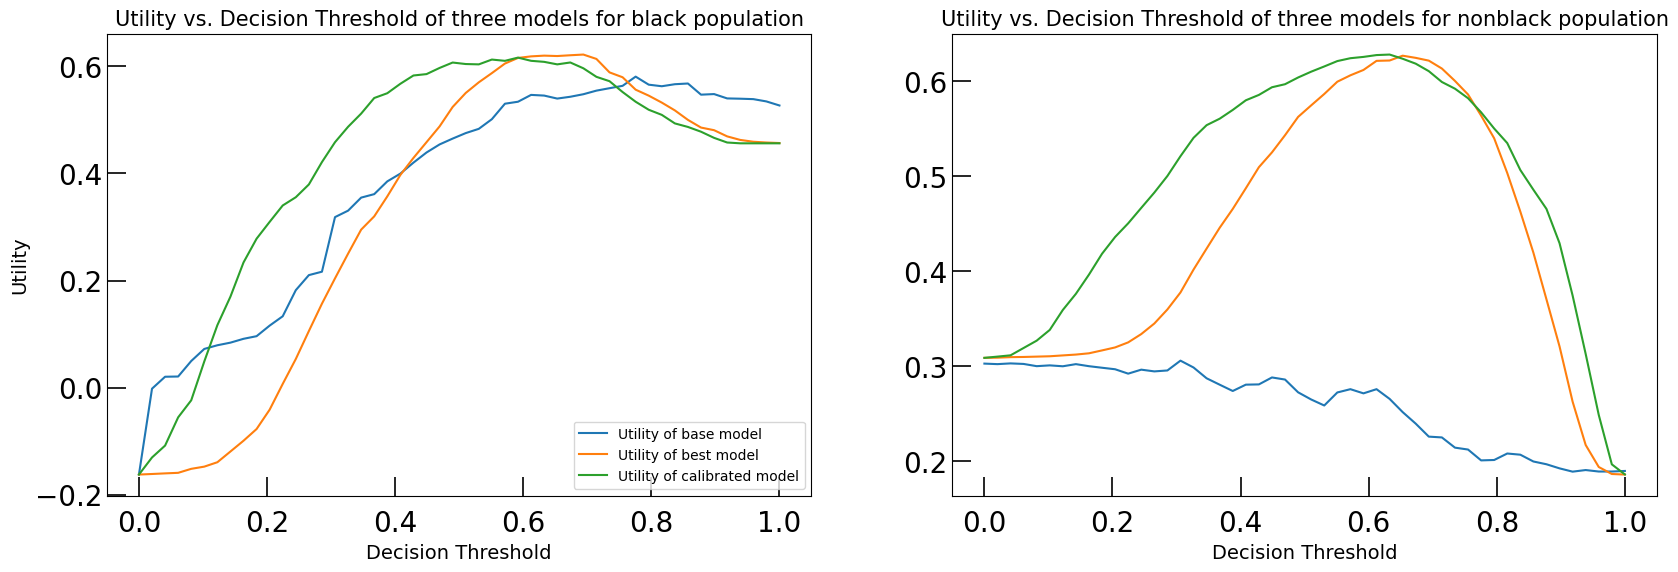

In [24]:
X_test_black = X_test[black_msk]
y_test_black = y_test[black_msk]
X_test_nonblack = X_test[nonblack_msk]
y_test_nonblack = y_test[nonblack_msk]

y_true_black = y_test_black.OWNER.to_numpy()
age_black = X_test_black.HHAGE.to_numpy()
y_true_nonblack = y_test_nonblack.OWNER.to_numpy()
age_nonblack = X_test_nonblack.HHAGE.to_numpy()

y_score= clf_base.predict(X_test_black)
p_base = (y_score - np.min(y_score) ) / (np.max(y_score) - np.min(y_score))
y_score = clf_best.predict(X_test_black)
p_best = (y_score - np.min(y_score) ) / (np.max(y_score) - np.min(y_score))
p_cali = clf_cali.predict_proba(X_test_black)[:,1]

utility_base_black = []
utility_best_black = []
utility_cali_black = []
utility_base_nonblack = []
utility_best_nonblack = []
utility_cali_nonblack = []
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
for t in th:
  utility_base_black.append(utility(p_base, y_true_black, age_black, t))
  utility_best_black.append(utility(p_best, y_true_black, age_black, t))
  utility_cali_black.append(utility(p_cali, y_true_black, age_black, t))

plt.plot(th, utility_base_black, label = 'Utility of base model')
plt.plot(th, utility_best_black, label = 'Utility of best model')
plt.plot(th, utility_cali_black, label = 'Utility of calibrated model')

plt.ylabel('Utility', size = 14)
plt.xlabel('Decision Threshold', size = 14)
plt.title('Utility vs. Decision Threshold of three models for black population', size = 15, wrap = True)
plt.legend(loc = 4)

y_score_base = clf_base.predict(X_test_nonblack)
p_base = (y_score - np.min(y_score) ) / (np.max(y_score) - np.min(y_score))
y_score = clf_best.predict(X_test_nonblack)
p_best = (y_score - np.min(y_score) ) / (np.max(y_score) - np.min(y_score))
p_cali = clf_cali.predict_proba(X_test_nonblack)[:,1]

plt.subplot(1,2,2)
for t in th:
  utility_base_nonblack.append(utility(p_base, y_true_nonblack, age_nonblack, t))
  utility_best_nonblack.append(utility(p_best, y_true_nonblack, age_nonblack, t))
  utility_cali_nonblack.append(utility(p_cali, y_true_nonblack, age_nonblack, t))

plt.plot(th, utility_base_nonblack, label = 'Utility of base model')
plt.plot(th, utility_best_nonblack, label = 'Utility of best model')
plt.plot(th, utility_cali_nonblack, label = 'Utility of calibrated model')

plt.xlabel('Decision Threshold', size = 14)
plt.title('Utility vs. Decision Threshold of three models for nonblack population', size = 15, wrap = True)


# THE END